In [10]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle
from nltk.corpus import stopwords

%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [11]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

# Data Load Functions

In [12]:
def extract_patterns(data,extract=False):
    if(extract):
        patterns = {}
        for index, row in data.iterrows():
            patterns[row['index']] = set(get_pattern([row['text']])[0].values())
            print('Extracted pattern from '+ row['index'] + ' index:'+ str(index))
            print('Size: ', len(patterns[row['index']]), 'Patterns size', len(patterns))
        try:
            print('Saving Pickle')
            with open('pickles/patterns/pattern.pickle','wb') as f:
                save = {
                    'patterns' : patterns
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved in pattern.pickle')
                return patterns
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
            return patterns
    else:
        try:
            with open('pickles/patterns/pattern.pickle','rb') as f:
                save = pickle.load(f)
                patterns = save['patterns']
                del save
                returning = {}
                for key in list(data['index']):
                    returning[key] = patterns[key]
                return returning
        except Exception as e:
            print('Error loading base datasets pickle: ', e)
            
def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def remove_empty_patterns(data,patterns):
    empty_patterns = [k for k, v in patterns.items() if len(v) < 1]
    patterns = { k:v for k, v in patterns.items() if len(v) >= 1 }
    data = filter(lambda x: x[1]['index'] not in empty_patterns ,data.iterrows())
    data = pd.DataFrame.from_items(data).T
    return data,patterns

In [13]:
def load_data(word_count,emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 2]
    #Remove rows that don't have Alignment file
    try:
        data = data.drop(no_alignment_file)
    except Exception as e:
        print('Error at: ',e)
    # Remove rows that have wrong Alignment file
    try:
        data = data.drop(wrong_alignment)
    except Exception as e:
        print('Error at: ',e)
#     Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
    patterns = extract_patterns(data)
    data,patterns = remove_empty_patterns(data,patterns)
    return data,patterns


In [14]:
# DATASET
TEST_SIZE      = 0.1

seed = 7
np.random.seed(seed)
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data, patterns = load_data(3,emotional_mapping)

x_train, x_test, y_train, y_test = train_test_split(data, data.emotion_code, test_size=TEST_SIZE)
data.groupby('emotion').count()

Error at:  labels [4764] not contained in axis
Error at:  labels [3730] not contained in axis


,index,start_time,end_time,text,wav_path,alignment_path,valence,arousal,dominance,gender,emotion_code
emotion,,,,,,,,,,,
ang,1141,1141,1141,1141,1141,1141,1141,1141,1141,1141,1141
sad,949,949,949,949,949,949,949,949,949,949,949


# Load PF-IEF and AcuWeight

In [9]:
em_df = pd.read_pickle('pickles/patterns/pfief_matrix.pickle')
full_acmatrix = pd.read_pickle('pickles/patterns/full_matrix.pickle')
cw_acmatrix = pd.read_pickle('pickles/patterns/cw_matrix.pickle')
wc_acmatrix = pd.read_pickle('pickles/patterns/wc_matrix.pickle')
patterns_list = np.array(list(em_df.index))

In [ ]:
def get_frequency_vectors(data,patterns_list):
    patterns = extract_patterns(data)
    transcript_order = list(data['index'])
    frequency_vectors = []
    for index in patterns:
        frequency_vectors.append(np.isin(patterns_list,np.array(list(patterns[index]))))
    vectors = pd.DataFrame(frequency_vectors,columns=patterns_list,index=patterns.keys())
    vectors = vectors.loc[transcript_order]
    vectors = vectors * 1
    return vectors

vectors = get_frequency_vectors(X_train,patterns_list)

In [242]:
scaled_feature_table_save = pd.read_pickle('pickles/patterns/scaled_pattern_features4emo.pickle')
scaled_feature_table = scaled_feature_table_save['feature_table']
del scaled_feature_table_save


# Parameter

In [243]:


# EMBEDDING
EMBEDDING_DIM  = 20
MAX_SEQ_LENGTH = 500

# MODEL
FILTER_SIZES   = [2,3]
FEATURE_MAPS   = [100,100]
DROPOUT_RATE   = 0.1

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 50
RUNS           = 5
VAL_SIZE       = 0.2
LEARNING_RATE  = 0.001

In [244]:
result = [len(scaled_feature_table[x].keys()) for x in x_train['index']]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
data = []
for key, row in x_train.iterrows():
    features = scaled_feature_table[row['index']]
    sorted(features)
#     sequences.append(features.values())
    feat_matrix = np.array(features.values())
    only_mfcc = feat_matrix[:,:20]
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:feat_matrix.shape[0],:feat_matrix.shape[1]] = only_mfcc#feat_matrix
    data.append(pad)


Text informations:
max length: 491 / min length: 1 / mean length: 46 / limit length: 500


In [245]:
pd.DataFrame(data[0])0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.656756,0.221400,1.069408,0.367141,0.750146,0.870579,0.398300,1.310045,0.525307,0.444163,1.172727,0.788089,1.114459,0.263879,0.619757,1.220436,0.478843,0.872219,0.937177,0.608437
1,-0.126000,0.493098,0.886391,0.725472,0.468955,0.774164,0.065364,1.155086,0.485525,0.258018,1.580656,0.743955,0.990792,0.168924,0.377787,0.604519,0.292407,0.551375,0.355610,0.870429
2,-0.393551,1.062238,0.735432,0.546050,-0.377471,1.465659,0.248456,1.111783,0.263105,0.443278,1.636533,-0.047891,1.372546,-0.110000,0.398228,0.865364,0.441178,0.809316,0.460121,0.785016
3,-0.179155,0.408821,0.873507,0.856978,0.638996,0.910599,0.269003,0.899412,0.438974,0.069423,1.088849,0.655628,0.536814,0.076873,0.579180,0.626273,-0.043224,0.377144,0.030184,0.731749
4,-0.252578,0.899407,0.791062,0.351358,0.024939,1.147683,0.215502,0.822546,0.323448,0.568299,1.676535,0.124892,1.061638,0.160715,0.319618,0.637860,0.360626,0.829016,0.358444,0.703502
5,-0.252578,0.899407,0.791062,0.351358,0.024939,1.147683,0.215502,0.822546,0.323448,0.568299,1.676535,0.124892,1.061638,0.160715,0.319618,0.637860,0.360626,0.829016,0.358444,0.703502
6,-0.180262,0.360136,0.824097,1.027186,0.644835,1.065416,0.206434,0.911147,0.409112,0.027121,1.347902,0.652015,0.454336,-0.047264,0.647781,0.723261,0.125469,0.506029,0.119630,0.709713
7,-0.555406,1.087756,0.862515,0.498137,0.170980,1.438073,0.190686,1.136525,0.279481,0.076930,1.269892,0.736619,1.379446,0.052554,0.818623,0.929769,0.304337,0.767010,0.451823,0.831215
8,-0.493263,0.694130,0.998848,0.669952,1.188908,1.103608,0.239194,0.784029,0.485665,0.002319,0.782806,0.921367,0.579476,-0.134514,0.282472,0.464485,-0.344201,0.569118,0.224076,0.374081
9,-0.126000,0.493098,0.886391,0.725472,0.468955,0.774164,0.065364,1.155086,0.485525,0.258018,1.580656,0.743955,0.990792,0.168924,0.377787,0.604519,0.292407,0.551375,0.355610,0.870429


In [246]:
import ap_cnn_model
np.array(data).shape, y_train.shape

((1914, 500, 20), (1914,))

In [251]:
histories = []
import time  
RUNS = 1
for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    start_time = time.time()
    X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)
    X_train = np.array(X_train)
    emb_layer = None
    
    model = ap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )
    
    history = model.fit(
        [X_train], labels,
        epochs=10,#NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([X_val], y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration', i+1)
    print("--- %s seconds on ---" % (time.time() - start_time))

Running iteration 1/1
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 20
Filter sizes: [2, 3]
Feature maps: [100, 100]
Max sequence: 500
#############################################
Train on 1531 samples, validate on 383 samples
Epoch 1/10
1531/1531 [==============================] - 5s 3ms/step - loss: 10.5052 - acc: 0.4664 - val_loss: 11.4880 - val_acc: 0.4047
Epoch 2/10
1531/1531 [==============================] - 3s 2ms/step - loss: 10.5047 - acc: 0.4664 - val_loss: 11.4875 - val_acc: 0.4047
Epoch 3/10
1531/1531 [==============================] - 3s 2ms/step - loss: 10.5042 - acc: 0.4664 - val_loss: 11.4870 - val_acc: 0.4047
Epoch 4/10
1531/1531 [==============================] - 3s 2ms/step - loss: 10.5038 - acc: 0.4664 - val_loss: 11.4865 - val_acc: 0.4047
Epoch 5/10
1531/1531 [==============================] - 3s 2ms/step - loss: 10.5033 - acc: 0.4664 - val_loss: 11.4860 - val_acc: 0.4047
Epoch 6/10
1531/153

In [252]:
print(np.array(X_train).shape, labels.shape)
print(np.array(X_val).shape, y_val.shape)
print(FILTER_SIZES,FEATURE_MAPS)


((1531, 500, 20), (1531,))
((383, 500, 20), (383,))
([2, 3], [100, 100])


In [255]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores

print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	10.5008 loss / 0.4664 acc
Validation: 	11.4835 loss / 0.4047 acc


In [111]:
def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

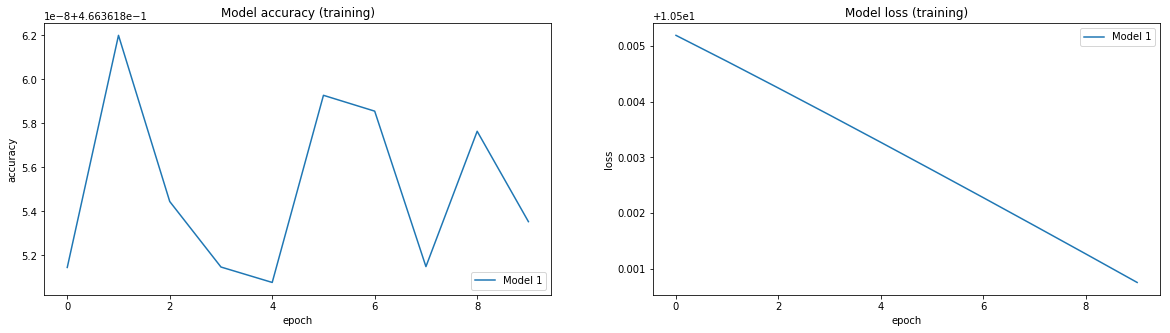

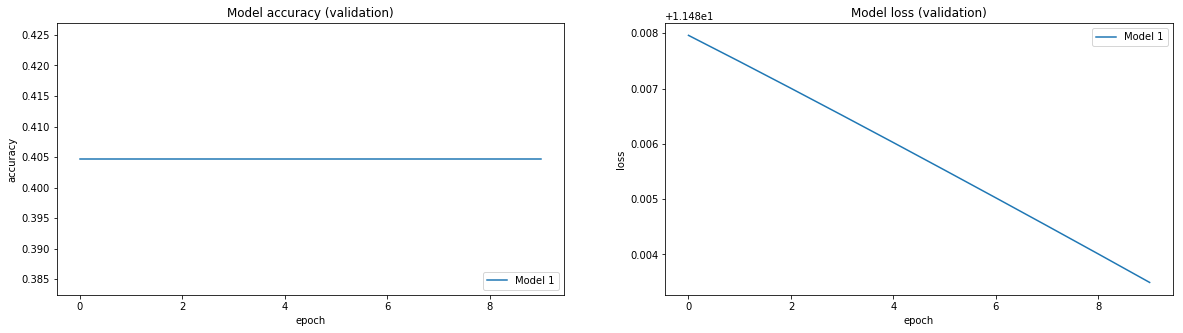

In [256]:
plot_acc_loss('training',histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

383/383 [==============================] - 0s 548us/step


(array([  0.,   0.,   0.,   0.,   0., 383.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

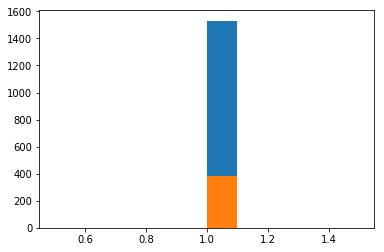

In [257]:
train_predictions = model.predict(X_train, verbose=1)
plt.hist(train_predictions)
test_predictions = model.predict([X_val],verbose=1)
plt.hist(test_predictions)

In [172]:
train_predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)